In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, optim

from utils import load_all_data, squeeze_and_concat, filter_mask_keep_labels, multiclass_dice_loss
from datasets import MultiTissueDataset, MultiTissueDatasetNoisyBkg
from unet_advanced import UNetAdvanced
from train_utils import EarlyStopping



%load_ext autoreload
%autoreload 2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f'Num available GPUs: ', torch.cuda.device_count())


p = torch.cuda.get_device_properties()
print(f"Device: {p.name} (Memory: {p.total_memory / 1e9:.2f} GB)")

Selected device: cuda
Num available GPUs:  1
Device: NVIDIA TITAN RTX (Memory: 25.19 GB)


In [3]:
# Data import 
DATA_FOLDER = "/scratch/pdiciano/GenAI/ACDC_mine/data/ACDC_tissue_prop"

data = load_all_data(DATA_FOLDER)
data_concat = squeeze_and_concat(data)

In [4]:
mask_keep_labels = [0, 1, 2, 3]  # ventricule right, ventricule left, myocardium right, myocardium left
data_concat['input_labels'] = filter_mask_keep_labels(data_concat['multiClassMasks'], mask_keep_labels)

In [5]:
def train(model, dataloader):
    lr = 1e-3
    epochs = 100

    patience = 10
    delta = 0.005

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True)

    model.to(device)
    model.train()
    
    metrics = {
        'loss': [],
        'dice_score': []
    }

    for epoch in range(epochs):
        running_loss = 0.0
        n_samples = 0

        with tqdm(dataloader, desc=f"Epoch {epoch+1}") as loop:

            for batch in loop:
                model.train()

                inputs = batch['input_label']  # (B, C, H, W)
                targets = batch['multiClassMask']  # (B, H, W)

                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs) 
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_size = inputs.size(0)
                n_samples += batch_size
                running_loss += loss.item() * batch_size
                current_average_loss = running_loss / n_samples

                loop.set_postfix({'loss: ': f'{current_average_loss:.2f}',
                                'lr: ': f"{optimizer.param_groups[0]['lr']:.2e}"})
        
        scheduler.step()
        dice_score = multiclass_dice_loss(outputs, targets).item()

        metrics['loss'].append(current_average_loss)
        metrics['dice_score'].append(dice_score)

        # Check early stopping condition
        early_stopping.check_early_stop(current_average_loss)
        
        if early_stopping.stop_training:
            print(f"Early stopping at epoch {epoch}")
            break

        print(f"Epoch {epoch+1}/{epochs}, Loss: {current_average_loss:.4f}, 1-Dice Score: {dice_score:.4f}")


    return model, metrics


## Train advanced UNet 1
training unet advanced (see module), images without background noise

In [ ]:
dataset = MultiTissueDataset(data_concat)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [9]:
model = UNetAdvanced(in_ch=4, num_classes=12).to(device)

trained_model, metrics = train(model, dataloader)
torch.save(trained_model.state_dict(), './models/multiTissue_advanced_unet.pth')

Epoch 1: 100%|██████████| 103/103 [01:08<00:00,  1.51it/s, loss: =1.30, lr: =1.00e-03]


Epoch 1/100, Loss: 1.3015, 1-Dice Score: 0.5228


Epoch 2: 100%|██████████| 103/103 [01:08<00:00,  1.50it/s, loss: =1.16, lr: =9.76e-04]


Epoch 2/100, Loss: 1.1571, 1-Dice Score: 0.5198


Epoch 3: 100%|██████████| 103/103 [01:08<00:00,  1.49it/s, loss: =1.12, lr: =9.05e-04]


Epoch 3/100, Loss: 1.1214, 1-Dice Score: 0.5153


Epoch 4: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.09, lr: =7.94e-04]


Epoch 4/100, Loss: 1.0858, 1-Dice Score: 0.4720


Epoch 5: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.06, lr: =6.55e-04]


Epoch 5/100, Loss: 1.0551, 1-Dice Score: 0.4811


Epoch 6: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.03, lr: =5.00e-04]


Epoch 6/100, Loss: 1.0294, 1-Dice Score: 0.4799


Epoch 7: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.01, lr: =3.45e-04]


Epoch 7/100, Loss: 1.0067, 1-Dice Score: 0.4812


Epoch 8: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.98, lr: =2.06e-04]


Epoch 8/100, Loss: 0.9838, 1-Dice Score: 0.4828


Epoch 9: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.96, lr: =9.55e-05]


Epoch 9/100, Loss: 0.9622, 1-Dice Score: 0.4601


Epoch 10: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.95, lr: =2.45e-05]


Epoch 10/100, Loss: 0.9465, 1-Dice Score: 0.4804


Epoch 11: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.04, lr: =1.00e-03]


Epoch 11/100, Loss: 1.0419, 1-Dice Score: 0.4895


Epoch 12: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.02, lr: =9.94e-04]


Epoch 12/100, Loss: 1.0187, 1-Dice Score: 0.4767


Epoch 13: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.00, lr: =9.76e-04]


Epoch 13/100, Loss: 1.0048, 1-Dice Score: 0.4836


Epoch 14: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.98, lr: =9.46e-04]


Epoch 14/100, Loss: 0.9799, 1-Dice Score: 0.4625


Epoch 15: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.97, lr: =9.05e-04]


Epoch 15/100, Loss: 0.9720, 1-Dice Score: 0.4657


Epoch 16: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.96, lr: =8.54e-04]


Epoch 16/100, Loss: 0.9649, 1-Dice Score: 0.4477


Epoch 17: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.94, lr: =7.94e-04]


Epoch 17/100, Loss: 0.9447, 1-Dice Score: 0.4504


Epoch 18: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.94, lr: =7.27e-04]


Epoch 18/100, Loss: 0.9359, 1-Dice Score: 0.4466


Epoch 19: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.92, lr: =6.55e-04]


Epoch 19/100, Loss: 0.9176, 1-Dice Score: 0.4360


Epoch 20: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.91, lr: =5.78e-04]


Epoch 20/100, Loss: 0.9067, 1-Dice Score: 0.4295


Epoch 21: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.90, lr: =5.00e-04]


Epoch 21/100, Loss: 0.8991, 1-Dice Score: 0.4414


Epoch 22: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.89, lr: =4.22e-04]


Epoch 22/100, Loss: 0.8855, 1-Dice Score: 0.4295


Epoch 23: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.87, lr: =3.45e-04]


Epoch 23/100, Loss: 0.8698, 1-Dice Score: 0.4269


Epoch 24: 100%|██████████| 103/103 [01:10<00:00,  1.46it/s, loss: =0.85, lr: =2.73e-04]


Epoch 24/100, Loss: 0.8502, 1-Dice Score: 0.4231


Epoch 25: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.83, lr: =2.06e-04]


Epoch 25/100, Loss: 0.8322, 1-Dice Score: 0.4183


Epoch 26: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.82, lr: =1.46e-04]


Epoch 26/100, Loss: 0.8178, 1-Dice Score: 0.4256


Epoch 27: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.80, lr: =9.55e-05]


Epoch 27/100, Loss: 0.8030, 1-Dice Score: 0.4338


Epoch 28: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.79, lr: =5.45e-05]


Epoch 28/100, Loss: 0.7884, 1-Dice Score: 0.4065


Epoch 29: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.78, lr: =2.45e-05]


Epoch 29/100, Loss: 0.7773, 1-Dice Score: 0.4242


Epoch 30: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.77, lr: =6.16e-06]


Epoch 30/100, Loss: 0.7684, 1-Dice Score: 0.3884


Epoch 31: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.92, lr: =1.00e-03]


Epoch 31/100, Loss: 0.9201, 1-Dice Score: 0.4138


Epoch 32: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.89, lr: =9.98e-04]


Epoch 32/100, Loss: 0.8925, 1-Dice Score: 0.4367


Epoch 33: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.88, lr: =9.94e-04]


Epoch 33/100, Loss: 0.8830, 1-Dice Score: 0.4143


Epoch 34: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.87, lr: =9.86e-04]


Epoch 34/100, Loss: 0.8749, 1-Dice Score: 0.4404


Epoch 35: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.86, lr: =9.76e-04]


Epoch 35/100, Loss: 0.8552, 1-Dice Score: 0.4095


Epoch 36: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.85, lr: =9.62e-04]


Epoch 36/100, Loss: 0.8454, 1-Dice Score: 0.4325


Epoch 37: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.84, lr: =9.46e-04]


Epoch 37/100, Loss: 0.8369, 1-Dice Score: 0.4204


Epoch 38: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.83, lr: =9.26e-04]


Epoch 38/100, Loss: 0.8286, 1-Dice Score: 0.4322


Epoch 39: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.80, lr: =9.05e-04]


Epoch 39/100, Loss: 0.7997, 1-Dice Score: 0.4101


Epoch 40: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.79, lr: =8.80e-04]


Stopping early as no improvement has been observed.
Early stopping at epoch 39


In [10]:
# Basic evaluation on the training set
batch = next(iter(dataloader))

state_dict = torch.load("././models/multiTissue_advanced_unet.pth")
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
    output = model(dataset[5]['input_label'].unsqueeze(0).to(device))
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    output_batch = model(batch['input_label'].to(device))
    pred_mask_batch = torch.argmax(output_batch, dim=1).cpu().numpy()

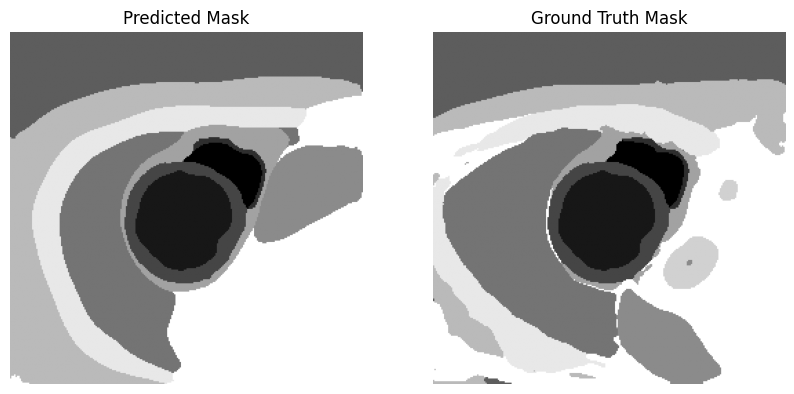

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pred_mask, cmap='gray')
ax[0].set_title('Predicted Mask')
ax[1].imshow(data_concat['multiClassMasks'][5], cmap='gray')
ax[1].set_title('Ground Truth Mask')

ax[0].axis('off')
ax[1].axis('off')
plt.show()

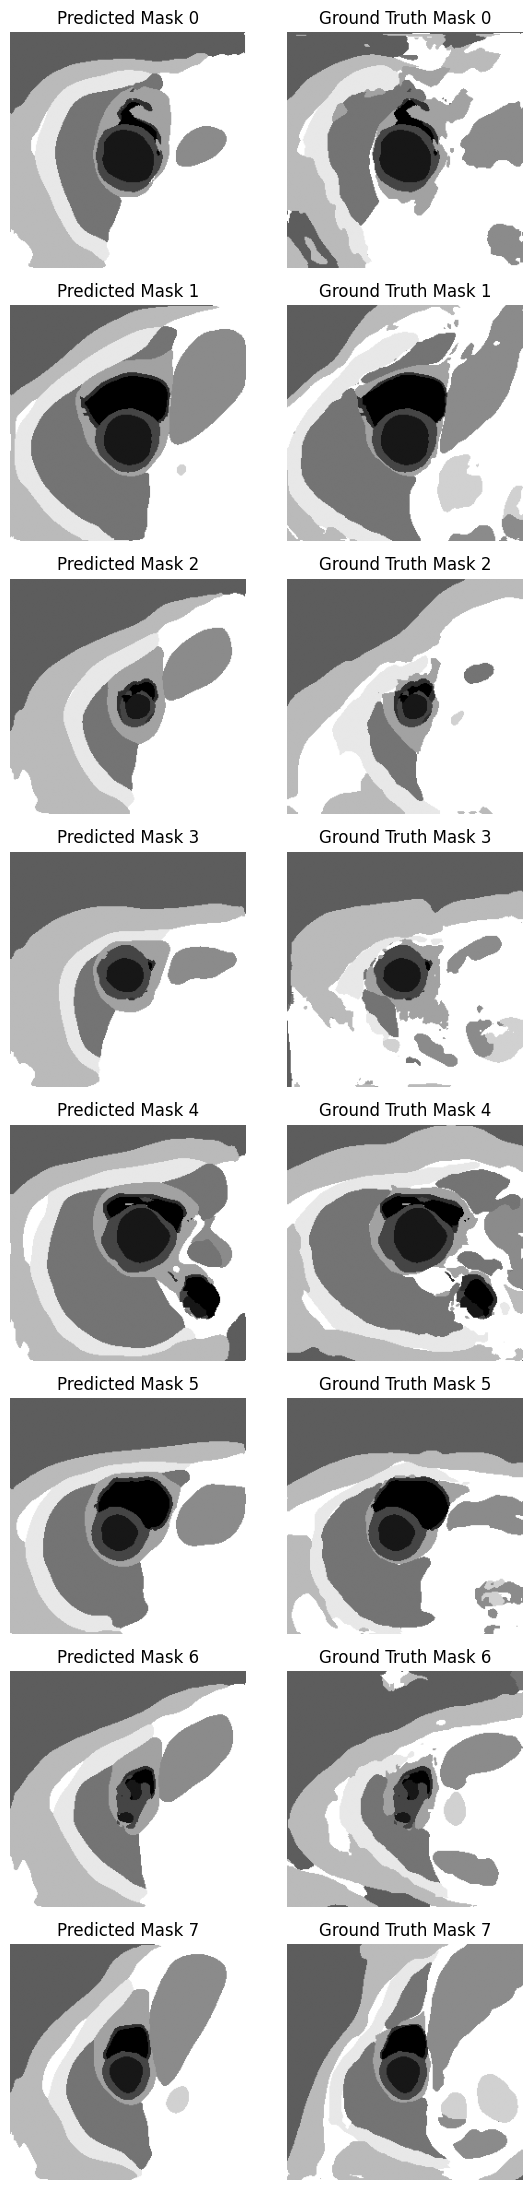

In [12]:
# Show all predicted batch
batch_size = pred_mask_batch.shape[0] // 2
fig, axes = plt.subplots(batch_size, 2, figsize=(6, 22))
for i in range(batch_size):
    axes[i, 0].imshow(pred_mask_batch[i], cmap='gray')
    axes[i, 0].set_title(f'Predicted Mask {i}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch['multiClassMask'][i].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

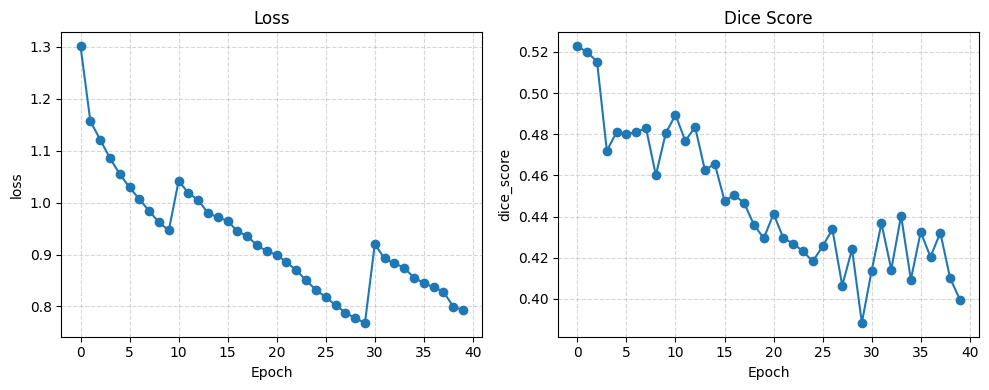

In [13]:
# for metrics 1
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

for ax, (key, values) in zip(axes, metrics.items()):
    ax.plot(values, marker='o')
    ax.set_title(key.replace('_', ' ').title())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(key)
    # ax.set_xticks(range(len(values)))
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Train advanced UNet 2 
Train with background noise (4 channels)

In [6]:
dataset = MultiTissueDatasetNoisyBkg(data_concat, variance=0.01, ignore_bkg=False)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
model = UNetAdvanced(in_ch=4, num_classes=12).to(device)

trained_model, metrics = train(model, dataloader)
torch.save(trained_model.state_dict(), './models/multiTissue_advanced_unet_2.pth')

Epoch 1: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =1.33, lr: =1.00e-03]


Epoch 1/100, Loss: 1.3304, 1-Dice Score: 0.4993


Epoch 2: 100%|██████████| 103/103 [01:47<00:00,  1.05s/it, loss: =1.19, lr: =9.76e-04]


Epoch 2/100, Loss: 1.1903, 1-Dice Score: 0.5235


Epoch 3: 100%|██████████| 103/103 [01:49<00:00,  1.07s/it, loss: =1.14, lr: =9.05e-04]


Epoch 3/100, Loss: 1.1371, 1-Dice Score: 0.5451


Epoch 4: 100%|██████████| 103/103 [01:49<00:00,  1.07s/it, loss: =1.10, lr: =7.94e-04]


Epoch 4/100, Loss: 1.1020, 1-Dice Score: 0.4739


Epoch 5: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =1.07, lr: =6.55e-04]


Epoch 5/100, Loss: 1.0727, 1-Dice Score: 0.4957


Epoch 6: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =1.06, lr: =5.00e-04]


Epoch 6/100, Loss: 1.0586, 1-Dice Score: 0.4793


Epoch 7: 100%|██████████| 103/103 [01:47<00:00,  1.04s/it, loss: =1.03, lr: =3.45e-04]


Epoch 7/100, Loss: 1.0314, 1-Dice Score: 0.5045


Epoch 8: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =1.01, lr: =2.06e-04]


Epoch 8/100, Loss: 1.0088, 1-Dice Score: 0.4859


Epoch 9: 100%|██████████| 103/103 [01:46<00:00,  1.03s/it, loss: =0.99, lr: =9.55e-05]


Epoch 9/100, Loss: 0.9949, 1-Dice Score: 0.4602


Epoch 10: 100%|██████████| 103/103 [01:46<00:00,  1.03s/it, loss: =0.98, lr: =2.45e-05]


Epoch 10/100, Loss: 0.9781, 1-Dice Score: 0.4686


Epoch 11: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =1.08, lr: =1.00e-03]


Epoch 11/100, Loss: 1.0760, 1-Dice Score: 0.4738


Epoch 12: 100%|██████████| 103/103 [01:48<00:00,  1.06s/it, loss: =1.04, lr: =9.94e-04]


Epoch 12/100, Loss: 1.0388, 1-Dice Score: 0.4711


Epoch 13: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =1.03, lr: =9.76e-04]


Epoch 13/100, Loss: 1.0269, 1-Dice Score: 0.4731


Epoch 14: 100%|██████████| 103/103 [01:46<00:00,  1.03s/it, loss: =1.02, lr: =9.46e-04]


Epoch 14/100, Loss: 1.0151, 1-Dice Score: 0.4515


Epoch 15: 100%|██████████| 103/103 [01:47<00:00,  1.04s/it, loss: =0.99, lr: =9.05e-04]


Epoch 15/100, Loss: 0.9932, 1-Dice Score: 0.4579


Epoch 16: 100%|██████████| 103/103 [01:40<00:00,  1.02it/s, loss: =0.98, lr: =8.54e-04]


Epoch 16/100, Loss: 0.9845, 1-Dice Score: 0.4737


Epoch 17: 100%|██████████| 103/103 [01:37<00:00,  1.06it/s, loss: =0.97, lr: =7.94e-04]


Epoch 17/100, Loss: 0.9715, 1-Dice Score: 0.4441


Epoch 18: 100%|██████████| 103/103 [01:36<00:00,  1.06it/s, loss: =0.96, lr: =7.27e-04]


Epoch 18/100, Loss: 0.9556, 1-Dice Score: 0.4703


Epoch 19: 100%|██████████| 103/103 [01:36<00:00,  1.06it/s, loss: =0.95, lr: =6.55e-04]


Epoch 19/100, Loss: 0.9470, 1-Dice Score: 0.4852


Epoch 20: 100%|██████████| 103/103 [01:39<00:00,  1.04it/s, loss: =0.93, lr: =5.78e-04]


Epoch 20/100, Loss: 0.9327, 1-Dice Score: 0.4436


Epoch 21: 100%|██████████| 103/103 [01:41<00:00,  1.02it/s, loss: =0.92, lr: =5.00e-04]


Epoch 21/100, Loss: 0.9218, 1-Dice Score: 0.4353


Epoch 22: 100%|██████████| 103/103 [01:41<00:00,  1.01it/s, loss: =0.90, lr: =4.22e-04]


Epoch 22/100, Loss: 0.9021, 1-Dice Score: 0.4293


Epoch 23: 100%|██████████| 103/103 [01:44<00:00,  1.01s/it, loss: =0.89, lr: =3.45e-04]


Epoch 23/100, Loss: 0.8932, 1-Dice Score: 0.4240


Epoch 24: 100%|██████████| 103/103 [01:42<00:00,  1.00it/s, loss: =0.87, lr: =2.73e-04]


Epoch 24/100, Loss: 0.8730, 1-Dice Score: 0.4170


Epoch 25: 100%|██████████| 103/103 [01:41<00:00,  1.01it/s, loss: =0.85, lr: =2.06e-04]


Epoch 25/100, Loss: 0.8540, 1-Dice Score: 0.4117


Epoch 26: 100%|██████████| 103/103 [01:42<00:00,  1.00it/s, loss: =0.83, lr: =1.46e-04]


Epoch 26/100, Loss: 0.8329, 1-Dice Score: 0.4343


Epoch 27: 100%|██████████| 103/103 [01:43<00:00,  1.01s/it, loss: =0.82, lr: =9.55e-05]


Epoch 27/100, Loss: 0.8194, 1-Dice Score: 0.4377


Epoch 28: 100%|██████████| 103/103 [01:42<00:00,  1.01it/s, loss: =0.80, lr: =5.45e-05]


Epoch 28/100, Loss: 0.8037, 1-Dice Score: 0.3859


Epoch 29: 100%|██████████| 103/103 [01:42<00:00,  1.00it/s, loss: =0.79, lr: =2.45e-05]


Epoch 29/100, Loss: 0.7920, 1-Dice Score: 0.4231


Epoch 30: 100%|██████████| 103/103 [01:44<00:00,  1.01s/it, loss: =0.79, lr: =6.16e-06]


Epoch 30/100, Loss: 0.7861, 1-Dice Score: 0.4144


Epoch 31: 100%|██████████| 103/103 [01:43<00:00,  1.01s/it, loss: =0.93, lr: =1.00e-03]


Epoch 31/100, Loss: 0.9250, 1-Dice Score: 0.4333


Epoch 32: 100%|██████████| 103/103 [01:43<00:00,  1.01s/it, loss: =0.91, lr: =9.98e-04]


Epoch 32/100, Loss: 0.9066, 1-Dice Score: 0.4394


Epoch 33: 100%|██████████| 103/103 [01:45<00:00,  1.03s/it, loss: =0.90, lr: =9.94e-04]


Epoch 33/100, Loss: 0.8966, 1-Dice Score: 0.4441


Epoch 34: 100%|██████████| 103/103 [01:49<00:00,  1.06s/it, loss: =0.87, lr: =9.86e-04]


Epoch 34/100, Loss: 0.8694, 1-Dice Score: 0.4472


Epoch 35: 100%|██████████| 103/103 [01:53<00:00,  1.10s/it, loss: =0.86, lr: =9.76e-04]


Epoch 35/100, Loss: 0.8591, 1-Dice Score: 0.4277


Epoch 36: 100%|██████████| 103/103 [01:53<00:00,  1.10s/it, loss: =0.84, lr: =9.62e-04]


Epoch 36/100, Loss: 0.8408, 1-Dice Score: 0.4291


Epoch 37: 100%|██████████| 103/103 [01:50<00:00,  1.07s/it, loss: =0.83, lr: =9.46e-04]


Epoch 37/100, Loss: 0.8306, 1-Dice Score: 0.4376


Epoch 38: 100%|██████████| 103/103 [01:56<00:00,  1.13s/it, loss: =0.81, lr: =9.26e-04]


Epoch 38/100, Loss: 0.8090, 1-Dice Score: 0.4374


Epoch 39: 100%|██████████| 103/103 [01:51<00:00,  1.08s/it, loss: =0.80, lr: =9.05e-04]


Epoch 39/100, Loss: 0.7956, 1-Dice Score: 0.4013


Epoch 40: 100%|██████████| 103/103 [01:47<00:00,  1.04s/it, loss: =0.78, lr: =8.80e-04]


Epoch 40/100, Loss: 0.7801, 1-Dice Score: 0.4331


Epoch 41: 100%|██████████| 103/103 [01:47<00:00,  1.05s/it, loss: =0.75, lr: =8.54e-04]


Epoch 41/100, Loss: 0.7530, 1-Dice Score: 0.4033


Epoch 42: 100%|██████████| 103/103 [01:49<00:00,  1.07s/it, loss: =0.74, lr: =8.25e-04]


Epoch 42/100, Loss: 0.7376, 1-Dice Score: 0.3700


Epoch 43: 100%|██████████| 103/103 [01:49<00:00,  1.07s/it, loss: =0.71, lr: =7.94e-04]


Epoch 43/100, Loss: 0.7135, 1-Dice Score: 0.3768


Epoch 44: 100%|██████████| 103/103 [01:50<00:00,  1.07s/it, loss: =0.68, lr: =7.61e-04]


Epoch 44/100, Loss: 0.6836, 1-Dice Score: 0.3738


Epoch 45: 100%|██████████| 103/103 [01:47<00:00,  1.05s/it, loss: =0.66, lr: =7.27e-04]


Epoch 45/100, Loss: 0.6616, 1-Dice Score: 0.3789


Epoch 46: 100%|██████████| 103/103 [01:50<00:00,  1.08s/it, loss: =0.64, lr: =6.91e-04]


Epoch 46/100, Loss: 0.6386, 1-Dice Score: 0.3759


Epoch 47: 100%|██████████| 103/103 [01:53<00:00,  1.10s/it, loss: =0.61, lr: =6.55e-04]


Epoch 47/100, Loss: 0.6118, 1-Dice Score: 0.3501


Epoch 48: 100%|██████████| 103/103 [01:55<00:00,  1.12s/it, loss: =0.58, lr: =6.17e-04]


Epoch 48/100, Loss: 0.5819, 1-Dice Score: 0.3674


Epoch 49: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =0.55, lr: =5.78e-04]


Epoch 49/100, Loss: 0.5548, 1-Dice Score: 0.2846


Epoch 50: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =0.54, lr: =5.39e-04]


Epoch 50/100, Loss: 0.5358, 1-Dice Score: 0.3139


Epoch 51: 100%|██████████| 103/103 [01:52<00:00,  1.09s/it, loss: =0.51, lr: =5.00e-04]


Epoch 51/100, Loss: 0.5075, 1-Dice Score: 0.3382


Epoch 52: 100%|██████████| 103/103 [01:50<00:00,  1.07s/it, loss: =0.49, lr: =4.61e-04]


Epoch 52/100, Loss: 0.4861, 1-Dice Score: 0.3146


Epoch 53: 100%|██████████| 103/103 [01:51<00:00,  1.09s/it, loss: =0.46, lr: =4.22e-04]


Epoch 53/100, Loss: 0.4608, 1-Dice Score: 0.2823


Epoch 54: 100%|██████████| 103/103 [01:51<00:00,  1.08s/it, loss: =0.44, lr: =3.83e-04]


Epoch 54/100, Loss: 0.4369, 1-Dice Score: 0.2502


Epoch 55: 100%|██████████| 103/103 [01:51<00:00,  1.08s/it, loss: =0.42, lr: =3.45e-04]


Epoch 55/100, Loss: 0.4191, 1-Dice Score: 0.2743


Epoch 56: 100%|██████████| 103/103 [01:52<00:00,  1.09s/it, loss: =0.40, lr: =3.09e-04]


Epoch 56/100, Loss: 0.3970, 1-Dice Score: 0.2429


Epoch 57: 100%|██████████| 103/103 [01:54<00:00,  1.11s/it, loss: =0.38, lr: =2.73e-04]


Epoch 57/100, Loss: 0.3818, 1-Dice Score: 0.2400


Epoch 58: 100%|██████████| 103/103 [01:49<00:00,  1.06s/it, loss: =0.36, lr: =2.39e-04]


Epoch 58/100, Loss: 0.3642, 1-Dice Score: 0.2655


Epoch 59: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =0.35, lr: =2.06e-04]


Epoch 59/100, Loss: 0.3492, 1-Dice Score: 0.2066


Epoch 60: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it, loss: =0.34, lr: =1.75e-04]


Epoch 60/100, Loss: 0.3355, 1-Dice Score: 0.2228


Epoch 61: 100%|██████████| 103/103 [01:50<00:00,  1.07s/it, loss: =0.32, lr: =1.46e-04]


Epoch 61/100, Loss: 0.3234, 1-Dice Score: 0.2200


Epoch 62: 100%|██████████| 103/103 [01:49<00:00,  1.07s/it, loss: =0.31, lr: =1.20e-04]


Epoch 62/100, Loss: 0.3128, 1-Dice Score: 0.2081


Epoch 63: 100%|██████████| 103/103 [01:50<00:00,  1.08s/it, loss: =0.30, lr: =9.55e-05]


Epoch 63/100, Loss: 0.3032, 1-Dice Score: 0.2209


Epoch 64: 100%|██████████| 103/103 [01:47<00:00,  1.04s/it, loss: =0.30, lr: =7.37e-05]


Epoch 64/100, Loss: 0.2964, 1-Dice Score: 0.2170


Epoch 65: 100%|██████████| 103/103 [01:46<00:00,  1.04s/it, loss: =0.29, lr: =5.45e-05]


Epoch 65/100, Loss: 0.2901, 1-Dice Score: 0.2403


Epoch 66: 100%|██████████| 103/103 [01:39<00:00,  1.03it/s, loss: =0.29, lr: =3.81e-05]


Epoch 66/100, Loss: 0.2859, 1-Dice Score: 0.1942


Epoch 67: 100%|██████████| 103/103 [01:37<00:00,  1.06it/s, loss: =0.28, lr: =2.45e-05]


Epoch 67/100, Loss: 0.2812, 1-Dice Score: 0.2281


Epoch 68: 100%|██████████| 103/103 [01:37<00:00,  1.06it/s, loss: =0.28, lr: =1.38e-05]


Epoch 68/100, Loss: 0.2800, 1-Dice Score: 0.1823


Epoch 69: 100%|██████████| 103/103 [01:37<00:00,  1.06it/s, loss: =0.28, lr: =6.16e-06]


Epoch 69/100, Loss: 0.2772, 1-Dice Score: 0.1902


Epoch 70: 100%|██████████| 103/103 [01:37<00:00,  1.05it/s, loss: =0.28, lr: =1.54e-06]


Epoch 70/100, Loss: 0.2758, 1-Dice Score: 0.2209


Epoch 71: 100%|██████████| 103/103 [01:38<00:00,  1.04it/s, loss: =0.55, lr: =1.00e-03]


Epoch 71/100, Loss: 0.5483, 1-Dice Score: 0.3360


Epoch 72: 100%|██████████| 103/103 [01:38<00:00,  1.05it/s, loss: =0.55, lr: =1.00e-03]


Epoch 72/100, Loss: 0.5466, 1-Dice Score: 0.3323


Epoch 73: 100%|██████████| 103/103 [01:39<00:00,  1.04it/s, loss: =0.49, lr: =9.98e-04]


Epoch 73/100, Loss: 0.4851, 1-Dice Score: 0.2920


Epoch 74: 100%|██████████| 103/103 [01:39<00:00,  1.04it/s, loss: =0.46, lr: =9.97e-04]


Epoch 74/100, Loss: 0.4551, 1-Dice Score: 0.2856


Epoch 75: 100%|██████████| 103/103 [01:40<00:00,  1.03it/s, loss: =0.43, lr: =9.94e-04]


Epoch 75/100, Loss: 0.4297, 1-Dice Score: 0.2673


Epoch 76: 100%|██████████| 103/103 [01:39<00:00,  1.04it/s, loss: =0.41, lr: =9.90e-04]


Epoch 76/100, Loss: 0.4072, 1-Dice Score: 0.2591


Epoch 77: 100%|██████████| 103/103 [01:39<00:00,  1.03it/s, loss: =0.39, lr: =9.86e-04]


Epoch 77/100, Loss: 0.3926, 1-Dice Score: 0.2834


Epoch 78: 100%|██████████| 103/103 [01:41<00:00,  1.02it/s, loss: =0.38, lr: =9.81e-04]


Epoch 78/100, Loss: 0.3780, 1-Dice Score: 0.2545


Epoch 79: 100%|██████████| 103/103 [01:42<00:00,  1.01it/s, loss: =0.37, lr: =9.76e-04]


Epoch 79/100, Loss: 0.3653, 1-Dice Score: 0.2554


Epoch 80: 100%|██████████| 103/103 [01:42<00:00,  1.01it/s, loss: =0.35, lr: =9.69e-04]


Stopping early as no improvement has been observed.
Early stopping at epoch 79


In [8]:
# Basic evaluation on the training set
batch = next(iter(dataloader))

state_dict = torch.load("././models/multiTissue_advanced_unet_2.pth")
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
    output = model(dataset[5]['input_label'].unsqueeze(0).to(device))
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    output_batch = model(batch['input_label'].to(device))
    pred_mask_batch = torch.argmax(output_batch, dim=1).cpu().numpy()

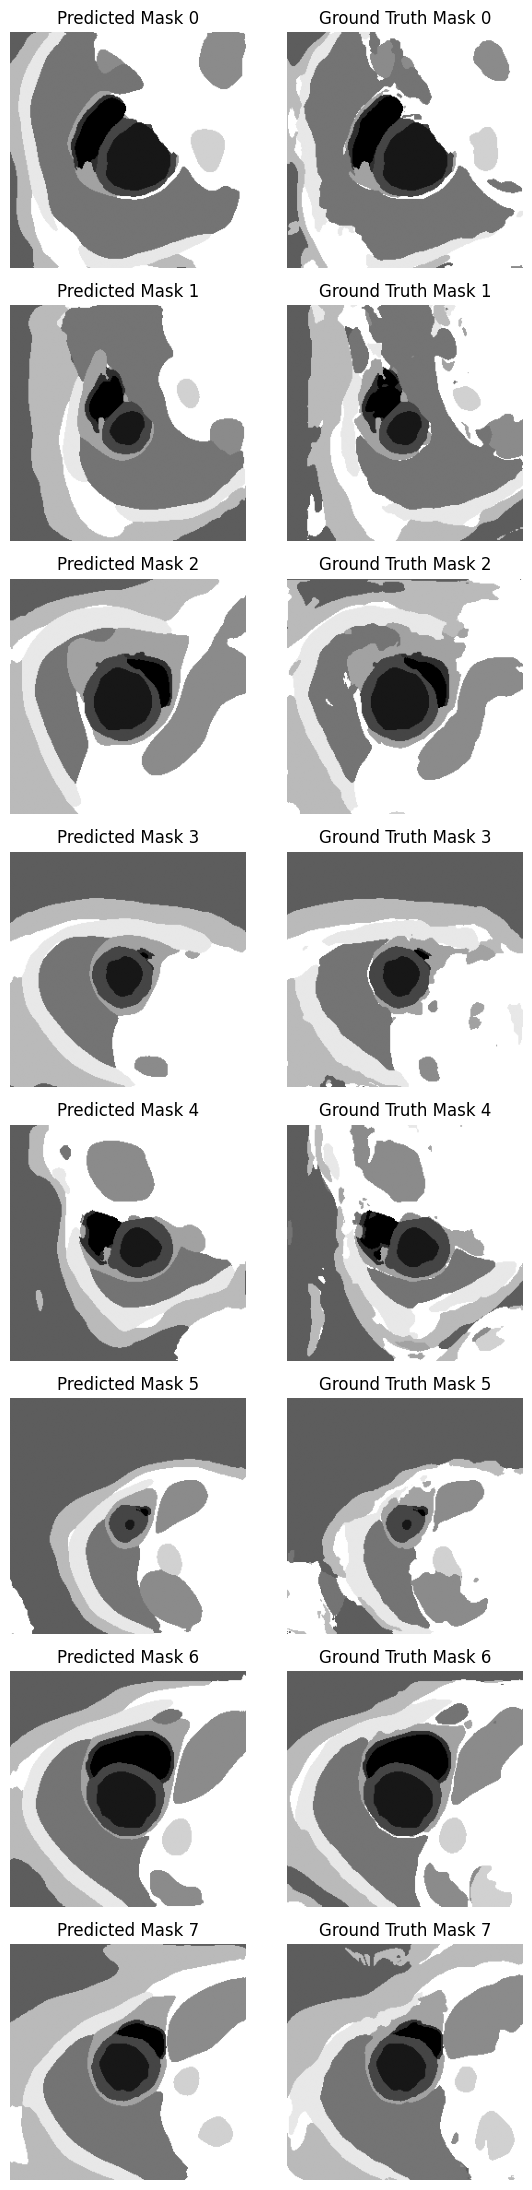

In [9]:
# Show all predicted batch
batch_size = pred_mask_batch.shape[0] // 2
fig, axes = plt.subplots(batch_size, 2, figsize=(6, 22))
for i in range(batch_size):
    axes[i, 0].imshow(pred_mask_batch[i], cmap='gray')
    axes[i, 0].set_title(f'Predicted Mask {i}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch['multiClassMask'][i].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

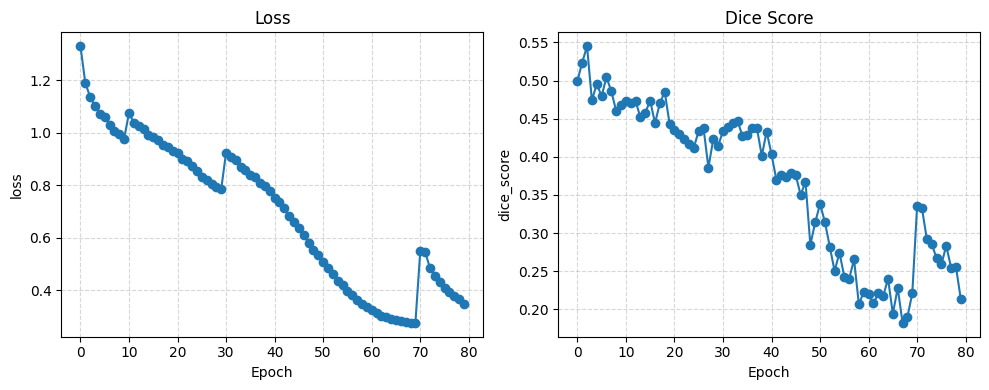

In [10]:
# for metrics 1
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

for ax, (key, values) in zip(axes, metrics.items()):
    ax.plot(values, marker='o')
    ax.set_title(key.replace('_', ' ').title())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(key)
    # ax.set_xticks(range(len(values)))
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()